# Content Based Model

In [17]:
## data
import numpy as np
import pandas as pd
from datetime import datetime

## visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## ML
from sklearn import metrics, preprocessing

## deep learning
import tensorflow as tf
from tensorflow.keras import models, layers, utils  


# Loading Data

In [2]:
## load movies data
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
## load user ratings data
users = pd.read_csv("data/ratings.csv")
users.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Data Cleaning

In [4]:
## Movies

## assign new movie id to "movie"
movies["movie"] = range(0,len(movies))

## extract the movie's name from the "title" column
movies["name"] = movies["title"].str.split(r"(").str[0]

## extract the movie's year from the "title" column
movies["year"] = movies["title"].apply(lambda x: int(x.split(r"(")[-1][0:4]) if r"(" in x else np.nan)

## new feature: "old" is True if year is < 2000, o/w False
movies["old"] = movies["year"].apply(lambda x: 1 if x < 2000 else 0)
movies.head()

,movieId,title,genres,movie,name,year,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1


In [5]:
## Users

## scale new user id starting at 0 and assign to "user"
users["user"] = users["userId"].apply(lambda x: x-1)

## converting timestamp int into Timestamp
users["timestamp"] = users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))

## flagging if timestamp is during the daytime
users["daytime"] = users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)

## flagging if timestamp is on the weekend
users["weekend"] = users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

## adding new movie id column "movie" to users df
users = users.merge(movies[["movieId","movie"]], how="left")

## rename "rating" to "y" (this is our target variable)
users = users.rename(columns={"rating":"y"})
users.head()

,userId,movieId,y,timestamp,user,daytime,weekend,movie
0,1,1,4.0,2000-07-30 11:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 11:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 11:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 12:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 11:48:51,0,1,1,46


In [6]:
## clean movies
movies = movies[["movie","name","old","genres"]].set_index("movie")
movies.head()

,name,old,genres
movie,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [7]:
## clean users
users = users[["user","movie","daytime","weekend","y"]]
users.head()

,user,movie,daytime,weekend,y
0,0,0,1,1,4.0
1,0,2,1,1,4.0
2,0,5,1,1,4.0
3,0,43,1,1,5.0
4,0,46,1,1,5.0


In [8]:
## saving other features into context if needed later
context = users[["user","movie","daytime","weekend"]]
context.head()

,user,movie,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


In [9]:
## Create Movies x Features dataframe
movies_features = pd.DataFrame({"old":movies["old"]})


## One-Hot-Encode genres
genres = list(movies["genres"].str.split(r"|"))
temp = genres[0]
for i in range(1, len(genres)):
    temp.extend(genres[i])

new_cols = list(set(temp))
new_cols.remove("(no genres listed)")
for col in new_cols:
    movies_features[col] = movies["genres"].str.contains(col).astype(int)
movies_features.head()

,old,Action,Sci-Fi,Adventure,Film-Noir,Documentary,Mystery,Thriller,Fantasy,War,Romance,Drama,Children,Crime,Horror,Western,IMAX,Animation,Musical,Comedy
movie,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [10]:
## Create Users x Movies dataframe
users_tmp = users.copy()
users_movies = users_tmp.pivot(index="user", columns="movie", values="y")

missing_cols = list(set(movies.index) - set(users_movies.columns))
for col in missing_cols:
    users_movies[col] = np.nan
users_movies = users_movies[sorted(users_movies.columns)]

## scale all ratings between 0.5 and 1
users_movies = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(users_movies.values), columns=users_movies.columns, index=users_movies.index)
users_movies

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


movie,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Understanding the Data

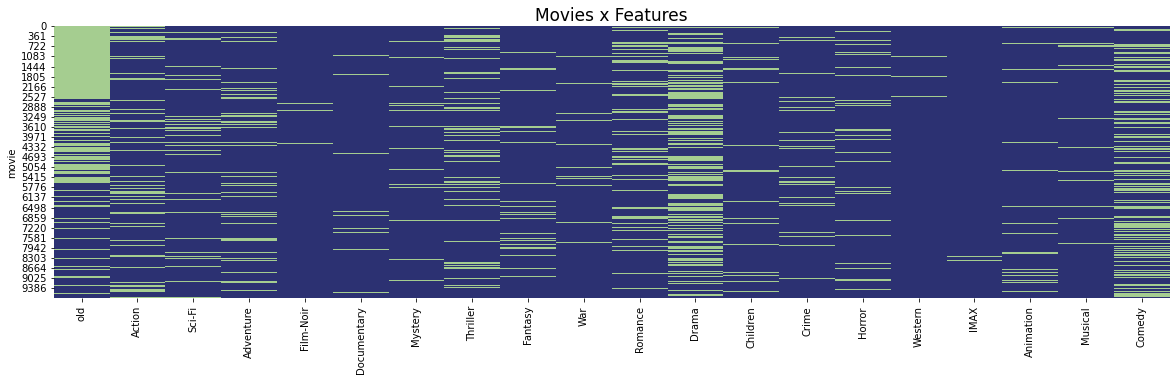

In [11]:
## heatmap: Movies x Features
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(movies_features==0, vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Movies x Features", size=17)
plt.show()

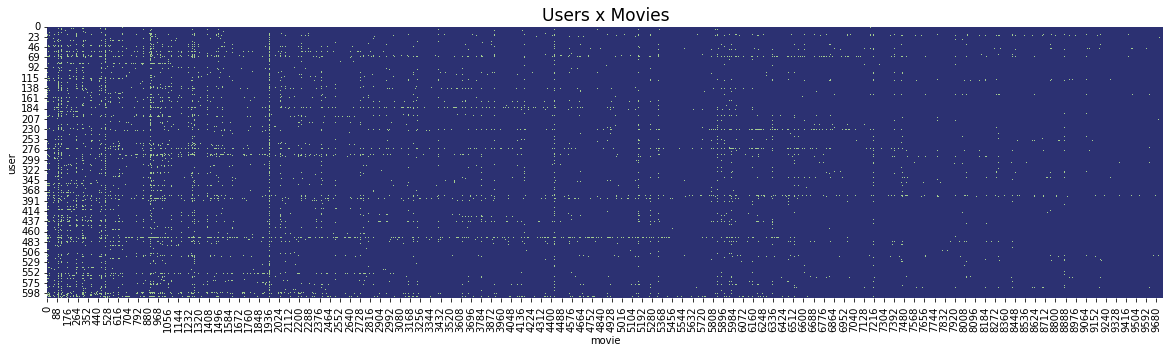

In [12]:
## heatmap: Users X Movies
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(users_movies.isnull(), vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Users x Movies", size=17)
plt.show()

# Train and Test Split

In [13]:
## Represent all users in both train and test dataframes
## Include 80% of movies in train dataframe and 20% in test dataframe

## split users x movies df vertically at 80/20 split
split = int(0.8*users_movies.shape[1])
users_movies_train = users_movies.loc[:, :split-1]
users_movies_test = users_movies.loc[:, split:]
print("---Train and Test Shapes---")
print("Users x Movies Train: ", users_movies_train.shape)
print("Users x Movies Test: ", users_movies_test.shape)

## split movies x features df horizontally at 80/20 split 
split = int(0.8*users_movies.shape[1])
movies_features_train = movies_features.loc[:split-1, :]
movies_features_test = movies_features.loc[split:, :]

print("Movies x Features Train: ", movies_features_train.shape)
print("Movies x Features Test: ", movies_features_test.shape)

---Train and Test Shapes---
Users x Movies Train:  (610, 7793)
Users x Movies Test:  (610, 1949)
Movies x Features Train:  (7793, 20)
Movies x Features Test:  (1949, 20)


In [14]:
def trainContestBasedRecommender(users_movies_df, movies_features_df):
    """
    Returns users x features weightings.
    args:
        users_movies_df [(int) x, (int) z]: users x movies true rating 
        movies_features_df [(int) z, (int) y]: one-hot movies x features matrix
    returns:
        ret [(int) x, (int) y]: users x features weightings 
    """
    users_movies_df = users_movies_df.fillna(0)
    users_features_df = tf.matmul(users_movies_df, movies_features_df)
    return users_features_df / tf.reduce_sum(users_features_df, axis=1, keepdims=True)

def applyContentBasedRecommender(users_features_df, movies_features_df):
    """
    Returns user x movie recommendations.
    args:
        users_features_df [(int) x, (int) y]: users x features weightings
        movies_features_df [(int) z, (int) y]: one-hot movies x features matrix
    returns:
        ret [(int) x, (int) z]: users x movies recommendations scaled between 0-1
    """
    return tf.matmul(users_features_df, movies_features_df.T)


In [18]:
## train model on training datasets
users_features_df = trainContestBasedRecommender(users_movies_train, movies_features_train)

## apply model to training data
train_yhat = applyContentBasedRecommender(users_features_df, movies_features_train)
train_yhat

<tf.Tensor: shape=(610, 7793), dtype=float64, numpy=
array([[0.55857013, 0.43684635, 0.36244913, ..., 0.16348729, 0.1706883 ,
        0.10655629],
       [0.18528036, 0.08670776, 0.16940033, ..., 0.22476963, 0.36740881,
        0.25632892],
       [0.47653728, 0.40259672, 0.33685082, ..., 0.20834556, 0.19131701,
        0.0727669 ],
       ...,
       [0.4542457 , 0.31703673, 0.34041679, ..., 0.18070866, 0.20423408,
        0.15269166],
       [0.44921137, 0.3868767 , 0.37723014, ..., 0.11862283, 0.23362571,
        0.16442906],
       [0.33179511, 0.21016562, 0.22911749, ..., 0.23937804, 0.24373933,
        0.19375275]])>

In [1168]:
# train_eval = users_movies_train.stack(dropna=False).reset_index().rename({0:"y"}, axis=1)
# train_yhat_stacked = pd.DataFrame(train_yhat.numpy()).stack().reset_index().rename({0:"yhat"}, axis=1)
# train_eval = train_eval.merge(train_yhat_stacked, left_on=["user", "movie"], right_on=["level_0", "level_1"], how='inner')
# train_eval = train_eval.drop(["level_0", "level_1"], axis=1)
# train_eval = train_eval[~train_eval["y"].isna()]
# train_eval

In [1169]:
# # overall
# y_test = train_eval["y"]
# predicted = train_eval["yhat"]

# print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
# print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

In [1170]:
# train_yhat_stacked = pd.DataFrame(train_yhat.numpy()).stack().reset_index().rename({0:"yhat"}, axis=1)

In [1171]:
# train_yhat_stacked

In [1172]:
def unseenMovies(users_movies_df):
    """
    Returns a dictionary of each user's unseen movies.
    args:
        users_movies_df [(int) x, (int) z]: users x movies rating (null indicates unseen)
    returns:
        unseen_dict {user1: [movie1, movie2, ...], ...}: each user's unseen movies
    """
    unseen_dict = {}
    for user in range(len(users_movies_df)): 
        obs = users_movies_df.iloc[user, :]
        unseen_movies = obs[obs.isna()].index
        unseen_dict[user] = unseen_movies
    return unseen_dict

    

def hitRatio(y, yhat, unseen_dict, threshold=10):
    """
    Evaluates model's predictions based on hit ratio algorithm.
    args:
        y [(int) x, (int) z]: true users x movies rating matrix
        yhat [(int) x, (int) z]: model's prediction of users x movies rating matrix
        unseen_dict {user1: [movie1, movie2, ...], ...}: each user's unseen movies
        threshold (int) k: threshold that defines a hit prediction 
    returns:
        hit ratio: hit ratio @ threshold
    """
    hit = []
    interaction_pairings = y.stack(dropna=True).reset_index()
    movie_index_map = dict(zip(y.columns, range(y.shape[1])))
    for pair in range(len(interaction_pairings)):
        u = interaction_pairings.iloc[pair, 0]
        m = interaction_pairings.iloc[pair, 1]
        random_99_unseen = np.random.choice(unseen_dict[u], size=99, replace=False)
        hit_check_movies = np.append(random_99_unseen, m)
        hit_check_indices = [movie_index_map[movie] for movie in hit_check_movies]
        predictions = tf.gather(yhat[u], indices = hit_check_indices)
        df = pd.DataFrame({"movie": hit_check_movies, "yhat": predictions})
        top_preds = df.sort_values("yhat", ascending=False).iloc[:threshold, :]["movie"]
        if m in list(top_preds):
            hit.append(1)
        else:
            hit.append(0)
    return np.mean(hit)

In [ ]:
## Hit Ratio for train dataset
train_hit_ratio = hitRatio(users_movies_train, train_yhat, unseenMovies(users_movies_train), 15)
print("Train hit ratio: ", train_hit_ratio)

In [ ]:
## Apply model to test df
test_yhat = applyContentBasedRecommender(users_features_df, movies_features_test)
test_yhat

In [ ]:
## Hit Ratio for test dataset
test_hit_ratio = hitRatio(users_movies_test, test_yhat, unseenMovies(users_movies_test), 15)
print("Test hit ratio: ", test_hit_ratio)